# Alzhimer Disease detection USING DEEP LEARNING MODALS
GROUP MEMBERS:
*   VIRAJ RAINA - 202101040042
*    AKASH TOTRE - 202101090009



# MODALS WE USED IN OUR PROJECT:
1) VGG16
2) INCEPTION-V3
3) RESENT-50
4) ALEXNET

# IMPORT

In [1]:
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import random

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D, GlobalAveragePooling2D, concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionV3
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from sklearn.utils import shuffle

%matplotlib inline

# LOAD DATASET

In [2]:
import os
os.environ['KAGGLE_USERNAME'] = "aniketsinghraju"
os.environ['KAGGLE_KEY'] = "5d04f4fb1bd8611556f0bb54607f35bc"

!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy

Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): ODbL-1.0
 95% 68.0M/71.5M [00:00<00:00, 70.6MB/s]
100% 71.5M/71.5M [00:00<00:00, 76.7MB/s]


In [5]:
!unzip best-alzheimer-mri-dataset-99-accuracy.zip

Archive:  best-alzheimer-mri-dataset-99-accuracy.zip
replace Combined Dataset/test/Mild Impairment/1 (10).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# SET VARAIABLES

Found 8192 images belonging to 4 classes.
Found 2048 images belonging to 4 classes.


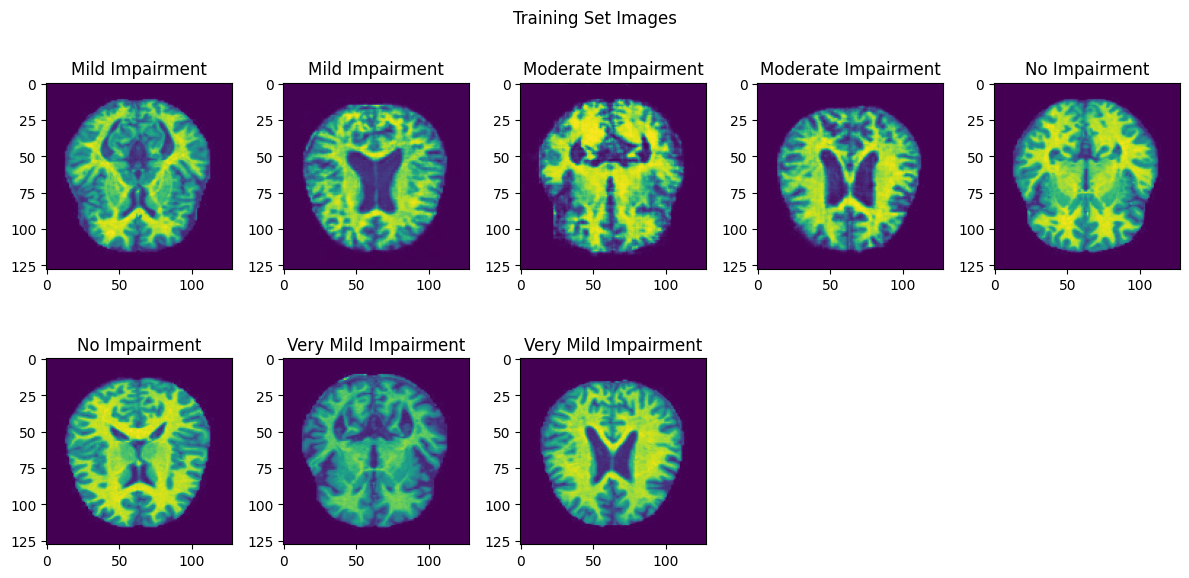

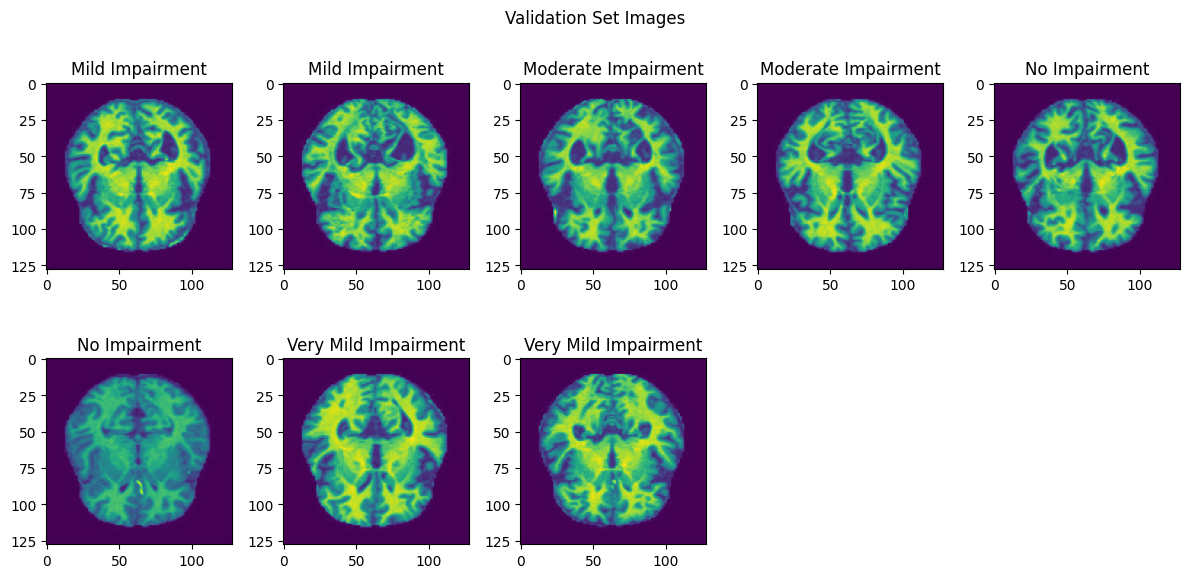

In [4]:
img_size = (150, 150)
batch_size = 32

data_dir = "/content/Combined Dataset/train"

category_names = sorted(os.listdir(data_dir))

datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

subset_images_train = []
subset_labels_train = []
class_counts_train = {cat: 0 for cat in category_names}
num_images_per_class = 2

for i in range(len(train_generator.filenames)):
    image_path = os.path.join(data_dir, train_generator.filenames[i])
    label = train_generator.labels[i]
    category_name = category_names[label]

    if class_counts_train[category_name] < num_images_per_class:
        img = plt.imread(image_path)
        subset_images_train.append(img)
        subset_labels_train.append(category_name)
        class_counts_train[category_name] += 1

subset_images_validation = []
subset_labels_validation = []
class_counts_validation = {cat: 0 for cat in category_names}

for i in range(len(validation_generator.filenames)):
    image_path = os.path.join(data_dir, validation_generator.filenames[i])
    label = validation_generator.labels[i]
    category_name = category_names[label]

    if class_counts_validation[category_name] < num_images_per_class:
        img = plt.imread(image_path)
        subset_images_validation.append(img)
        subset_labels_validation.append(category_name)
        class_counts_validation[category_name] += 1

plt.figure(figsize=(12, 6))
plt.suptitle("Training Set Images")
for i in range(len(subset_images_train)):
    plt.subplot(2,5,i+1)
    plt.imshow(subset_images_train[i])
    plt.title(subset_labels_train[i])
plt.tight_layout()

plt.figure(figsize=(12, 6))
plt.suptitle("Validation Set Images")
for i in range(len(subset_images_validation)):
    plt.subplot(2,5,i+1)
    plt.imshow(subset_images_validation[i])
    plt.title(subset_labels_validation[i])
plt.tight_layout()

plt.show()

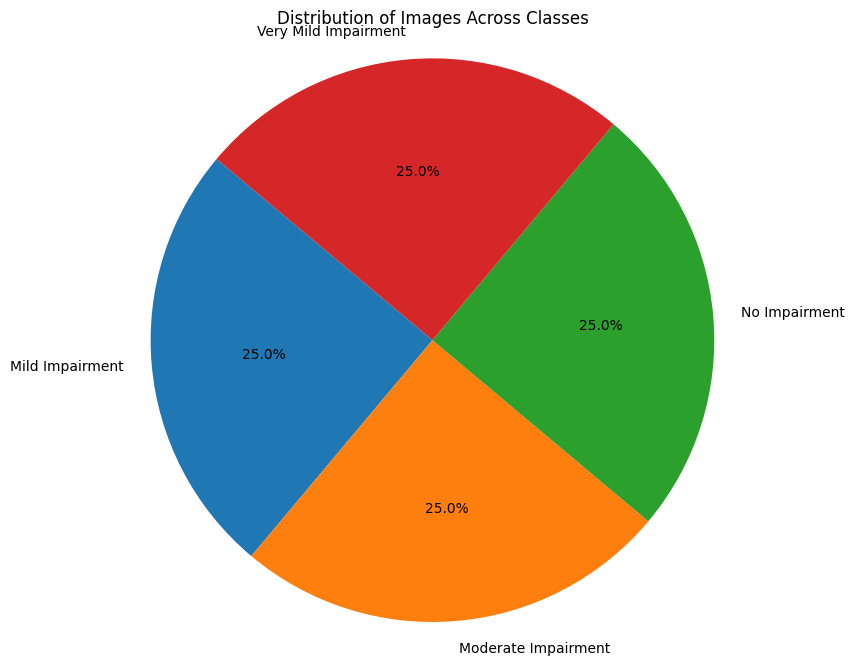

In [ ]:
class_names = list(train_generator.class_indices.keys())
class_counts = [train_generator.labels.tolist().count(class_index) for class_index in range(len(class_names))]

plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Images Across Classes')

plt.axis('equal')

plt.show()


# VGG16

In [ ]:
img_size = (150, 150)
batch_size = 32
num_classes = len(train_generator.class_indices)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=40,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    verbose=1
)

model.save('alzheimer_vgg16.h5')


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │         525,3

 Total params: 15,244,100 (58.15 MB)

 Trainable params: 529,412 (2.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 53s 320ms/step - accuracy: 0.2765 - loss: 1.4397 - val_accuracy: 0.3188 - val_loss: 1.3403
Epoch 2/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 43s 286ms/step - accuracy: 0.3462 - loss: 1.3460 - val_accuracy: 0.4326 - val_loss: 1.2897
Epoch 3/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 95s 307ms/step - accuracy: 0.4053 - loss: 1.2809 - val_accuracy: 0.4907 - val_loss: 1.2334
Epoch 4/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 241ms/step - accuracy: 0.4774 - loss: 1.2148 - val_accuracy: 0.4761 - val_loss: 1.2124
Epoch 5/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 49s 319ms/step - accuracy: 0.4796 - loss: 1.1930 - val_accuracy: 0.4946 - val_loss: 1.1793
Epoch 6/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - accuracy: 0.5156 - loss: 1.1336 - val_accuracy: 0.4800 - val_loss: 1.1725
Epoch 7/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 105s 314ms/step - accuracy: 0.5394 - loss: 1.1266 - val_accuracy: 0.5229 - val_loss: 1.1204
Epoch 8/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 34s 231ms/step - accuracy: 0.5485 - loss: 

# RESNET50

In [6]:
img_size = (150, 150)
batch_size = 32
num_classes = len(train_generator.class_indices)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=40,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    verbose=1
)
model.save('alzheimer_resnet50_40.h5')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 156, 156, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 75, 75, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 75, 75, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 75, 75, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 77, 77, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 38, 38, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 38, 38, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 38, 38, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 38, 38, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 38, 38, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,689,988 (98.00 MB)

 Trainable params: 2,102,276 (8.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


256/256 ━━━━━━━━━━━━━━━━━━━━ 83s 270ms/step - accuracy: 0.2631 - loss: 1.4789 - val_accuracy: 0.2852 - val_loss: 1.3561
Epoch 2/40
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/40


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


256/256 ━━━━━━━━━━━━━━━━━━━━ 65s 251ms/step - accuracy: 0.3224 - loss: 1.3685 - val_accuracy: 0.3286 - val_loss: 1.3270
Epoch 4/40
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 91us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/40
256/256 ━━━━━━━━━━━━━━━━━━━━ 83s 254ms/step - accuracy: 0.3539 - loss: 1.3279 - val_accuracy: 0.3735 - val_loss: 1.3219
Epoch 6/40
256/256 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/40
256/256 ━━━━━━━━━━━━━━━━━━━━ 74s 249ms/step - accuracy: 0.3601 - loss: 1.3085 - val_accuracy: 0.3999 - val_loss: 1.3015
Epoch 8/40
256/256 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/40
256/256 ━━━━━━━━━━━━━━━━━━━━ 65s 247ms/step - accuracy: 0.3893 - loss: 1.2914 - val_accuracy: 0.3975 - val_loss: 1.3004
Epoch 10/40
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 143us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/40
256/256 ━━━━━━━━━━━━━━━━━━━━ 82s 249ms/step - accuracy: 0.3899 - loss: 1.2835 - val_accuracy:

# INCEPTION

In [ ]:
img_size = (150, 150)
batch_size = 32
num_classes = len(train_generator.class_indices)

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=40,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    verbose=1
)

model.save('alzheimer_inception_40.h5')

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_94 (Conv2D)        │ (None, 74, 74, 32)     │            864 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_94    │ (None, 74, 74, 32)     │             96 │ conv2d_94[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_94             │ (None, 74, 74, 32)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 72, 72, 32)     │          9,216 │ activation_94[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_95    │ (None, 72, 72, 32)     │             96 │ conv2d_95[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_95             │ (None, 72, 72, 32)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 72, 72, 64)     │         18,432 │ activation_95[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_96    │ (None, 72, 72, 64)     │            192 │ conv2d_96[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_96             │ (None, 72, 72, 64)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 35, 35, 64)     │              0 │ activation_96[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 35, 35, 80)     │          5,120 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_97    │ (None, 35, 35, 80)     │            240 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_97             │ (None, 35, 35, 80)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)   

 Total params: 23,905,060 (91.19 MB)

 Trainable params: 2,102,276 (8.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/40
256/256 ━━━━━━━━━━━━━━━━━━━━ 80s 266ms/step - accuracy: 0.3855 - loss: 1.6475 - val_accuracy: 0.5557 - val_loss: 1.0102
Epoch 2/40
256/256 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/40
256/256 ━━━━━━━━━━━━━━━━━━━━ 68s 251ms/step - accuracy: 0.5231 - loss: 1.0702 - val_accuracy: 0.5645 - val_loss: 0.9407
Epoch 4/40
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 127us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/40
256/256 ━━━━━━━━━━━━━━━━━━━━ 66s 254ms/step - accuracy: 0.5603 - loss: 1.0164 - val_accuracy: 0.5991 - val_loss: 0.9186
Epoch 6/40
256/256 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/40
256/256 ━━━━━━━━━━━━━━━━━━━━ 71s 241ms/step - accuracy: 0.5782 - loss: 0.9540 - val_accuracy: 0.5952 - val_loss: 0.8904
Epoch 8/40
256/256 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/40
256/256 ━━━━━━━━━━━━━━━━━━━━ 63s 243ms/step - accuracy: 0.5911 - loss: 0.9307 - val_

# ALEXNET

In [ ]:
img_size = (150, 150)
batch_size = 32
input_layer = Input(shape=(img_size[0], img_size[1], 3))
x = Conv2D(96, (11, 11), strides=(4, 4), activation='relu')(input_layer)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)
x = Conv2D(256, (5, 5), activation='relu')(x)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)
x = Conv2D(384, (3, 3), activation='relu')(x)
x = Conv2D(384, (3, 3), activation='relu')(x)
x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=40,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    verbose=1
)
model.save('alzheimer_alexnet.h5')

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_188 (Conv2D)                  │ (None, 35, 35, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 17, 17, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_189 (Conv2D)                  │ (None, 13, 13, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_190 (Conv2D)                  │ (None, 4, 4, 384)           │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_191 (Conv2D)                  │ (None, 2, 2, 384)           │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_192 (Conv2D)                  │ (None, 2, 2, 256)           │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 4096)                │       1,052,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 4)                   │          16,388 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,597,572 (82.39 MB)

 Trainable params: 21,597,572 (82.39 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
256/256 ━━━━━━━━━━━━━━━━━━━━ 71s 243ms/step - accuracy: 0.2480 - loss: 1.3850 - val_accuracy: 0.4375 - val_loss: 1.2395
Epoch 2/40
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 71us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/40
256/256 ━━━━━━━━━━━━━━━━━━━━ 61s 234ms/step - accuracy: 0.4453 - loss: 1.1862 - val_accuracy: 0.6094 - val_loss: 0.8729
Epoch 4/40
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 42us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/40
256/256 ━━━━━━━━━━━━━━━━━━━━ 82s 233ms/step - accuracy: 0.6173 - loss: 0.8293 - val_accuracy: 0.7095 - val_loss: 0.6671
Epoch 6/40
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 52us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/40
256/256 ━━━━━━━━━━━━━━━━━━━━ 59s 227ms/step - accuracy: 0.6605 - loss: 0.7127 - val_accuracy: 0.7251 - val_loss: 0.6928
Epoch 8/40
256/256 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/40
256/256 ━━━━━━━━━━━━━━━━━━━━ 74s 230ms/step - accuracy: 0.6686 - loss: 0.6749 - val_a

# SAVE THE MODELS

In [7]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
!cp alzheimer_resnet50_40.h5 /content/drive/MyDrive/

# EVAL

Found 1279 images belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 235ms/step - accuracy: 0.5097 - loss: 1.0142
VGG16 - Test Accuracy: 54.42%
VGG16 - Test Loss: 0.9648
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step
VGG16 - Classification Report:
                       precision    recall  f1-score   support

     Mild Impairment       0.36      0.38      0.37       179
 Moderate Impairment       0.09      0.33      0.14        12
       No Impairment       0.65      0.67      0.66       640
Very Mild Impairment       0.46      0.39      0.42       448

            accuracy                           0.53      1279
           macro avg       0.39      0.44      0.40      1279
        weighted avg       0.53      0.53      0.53      1279



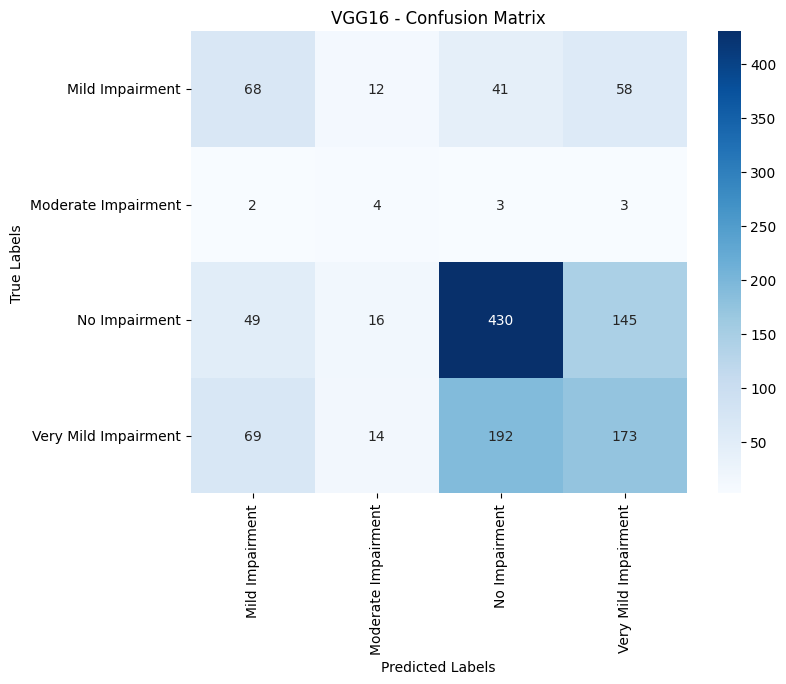

Found 1279 images belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - accuracy: 0.4138 - loss: 1.2228
ResNet50 - Test Accuracy: 42.46%
ResNet50 - Test Loss: 1.1840
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 231ms/step
ResNet50 - Classification Report:
                       precision    recall  f1-score   support

     Mild Impairment       0.23      0.16      0.19       179
 Moderate Impairment       0.03      0.50      0.05        12
       No Impairment       0.58      0.68      0.63       640
Very Mild Impairment       0.36      0.16      0.22       448

            accuracy                           0.42      1279
           macro avg       0.30      0.37      0.27      1279
        weighted avg       0.45      0.42      0.42      1279



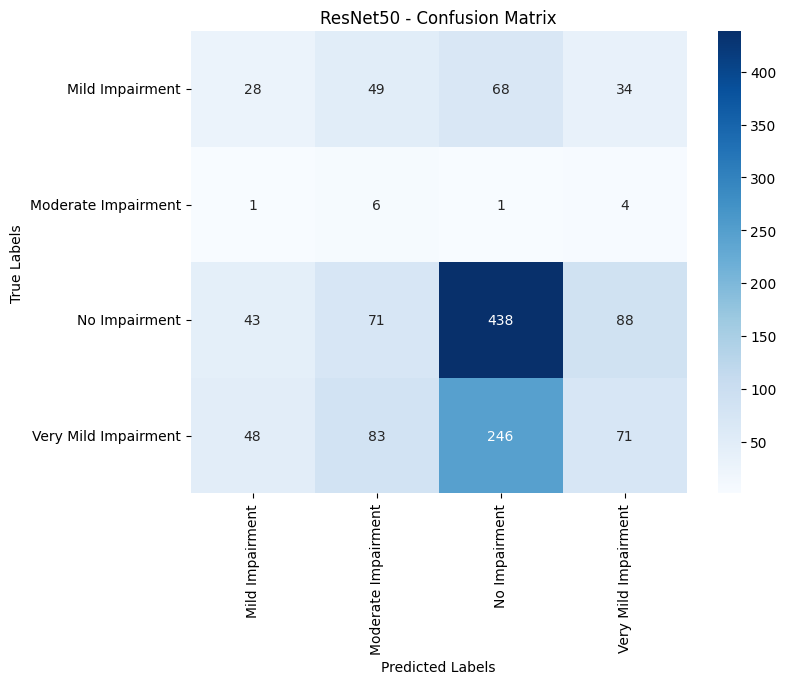

Found 1279 images belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 229ms/step - accuracy: 0.5677 - loss: 0.9693
InceptionV3 - Test Accuracy: 54.73%
InceptionV3 - Test Loss: 0.9370
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 290ms/step
InceptionV3 - Classification Report:
                       precision    recall  f1-score   support

     Mild Impairment       0.39      0.34      0.36       179
 Moderate Impairment       0.08      0.08      0.08        12
       No Impairment       0.58      0.84      0.69       640
Very Mild Impairment       0.49      0.20      0.29       448

            accuracy                           0.54      1279
           macro avg       0.38      0.37      0.35      1279
        weighted avg       0.52      0.54      0.50      1279



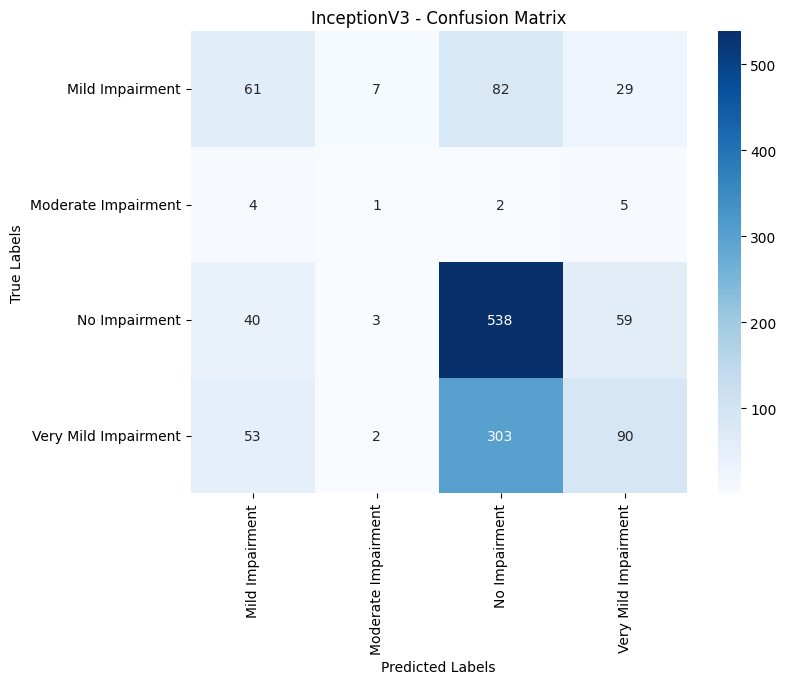

Found 1279 images belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 217ms/step - accuracy: 0.5924 - loss: 0.8624
AlexNet - Test Accuracy: 58.17%
AlexNet - Test Loss: 0.8575
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step
AlexNet - Classification Report:
                       precision    recall  f1-score   support

     Mild Impairment       0.44      0.49      0.46       179
 Moderate Impairment       1.00      0.50      0.67        12
       No Impairment       0.67      0.71      0.69       640
Very Mild Impairment       0.47      0.41      0.44       448

            accuracy                           0.57      1279
           macro avg       0.64      0.53      0.56      1279
        weighted avg       0.57      0.57      0.57      1279



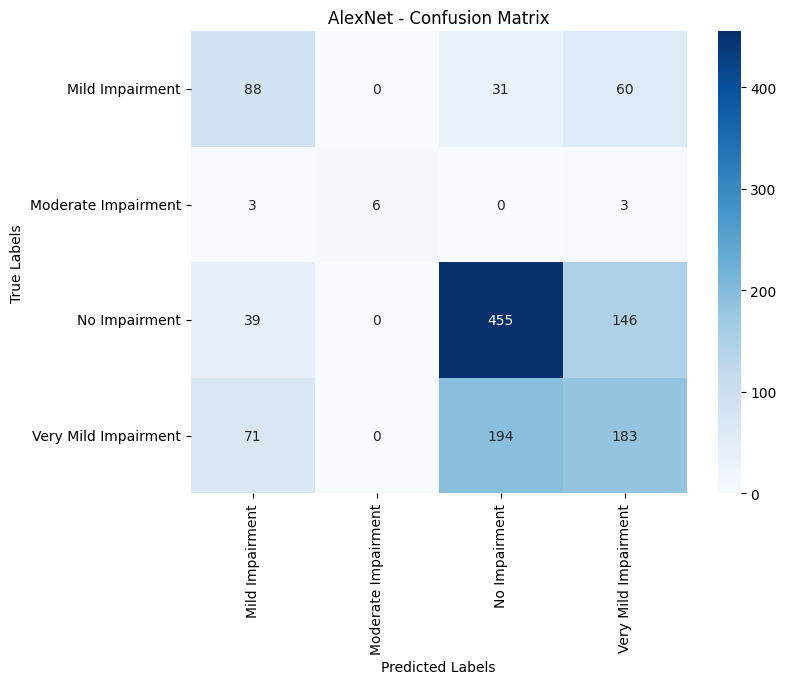

In [ ]:
def evaluate_model(model_name, model_filename):
    custom_model = load_model(model_filename)

    test_generator = datagen.flow_from_directory(
        "/content/Combined Dataset/test",
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    test_loss, test_accuracy = custom_model.evaluate(test_generator, verbose=1)
    print(f"{model_name} - Test Accuracy: {test_accuracy * 100:.2f}%")
    print(f"{model_name} - Test Loss: {test_loss:.4f}")

    predictions = custom_model.predict(test_generator)
    predicted_labels = np.argmax(predictions, axis=1)

    true_labels = test_generator.classes

    class_report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys())
    print(f"{model_name} - Classification Report:\n", class_report)

    confusion_mtx = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

evaluate_model("VGG16", "alzheimer_vgg16_40.h5")
evaluate_model("ResNet50", "alzheimer_resnet50_40.h5")
evaluate_model("InceptionV3", "alzheimer_inception_40.h5")
evaluate_model("AlexNet", "alzheimer_alexnet_40.h5")

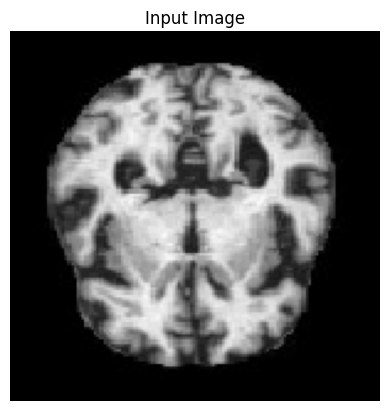

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
VGG16 Prediction: Mild Impairment
Confidence Scores: [0.690032   0.00656325 0.15104868 0.15235607]

InceptionV3 Prediction: Mild Impairment
Confidence Scores: [6.2403983e-01 9.7702621e-05 6.5274172e-02 3.1058836e-01]

AlexNet Prediction: Mild Impairment
Confidence Scores: [9.0663189e-01 1.3889793e-04 1.0717951e-02 8.2511283e-02]

ResNet50 Prediction: Moderate Impairment
Confidence Scores: [0.29382876 0.32801533 0.13538507 0.2427708 ]



In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the models
model_vgg16 = load_model('alzheimer_vgg16_40.h5')
model_inception = load_model('alzheimer_inception_40.h5')
model_alexnet = load_model('alzheimer_alexnet_40.h5')
model_resnet50 = load_model('alzheimer_resnet50_40.h5')  # Load ResNet50 model

# Define the image size (make sure it matches the models' expected input size)
img_size = (150, 150)

# Function to make a prediction and display results for multiple models
def predict_image(image_path, models, class_indices):
    # Load the image
    img = load_img(image_path, target_size=img_size)

    # Display the input image
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis('off')
    plt.show()

    # Convert image to array and preprocess
    img_array = img_to_array(img) / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Initialize a dictionary to store predictions
    predictions = {}

    # Predict with each model
    for model_name, model in models.items():
        pred = model.predict(img_array)
        predicted_class = np.argmax(pred, axis=1)[0]  # Get the predicted class index
        class_labels = {v: k for k, v in class_indices.items()}  # Reverse the class indices
        predicted_label = class_labels[predicted_class]  # Get the predicted class label
        predictions[model_name] = {'label': predicted_label, 'confidence': pred[0]}

    # Print out the predictions for each model
    for model_name, result in predictions.items():
        print(f"{model_name} Prediction: {result['label']}")
        print(f"Confidence Scores: {result['confidence']}\n")

    return predictions

# Path to the image you want to test
image_path = "/content/Combined Dataset/test/Mild Impairment/1 (10).jpg"

# Class indices (replace with your actual class mapping from the generator)
class_indices = {'Mild Impairment': 0, 'Moderate Impairment': 1, 'No Impairment': 2, 'Very Mild Impairment': 3}  # Example

# List of models
models = {
    'VGG16': model_vgg16,
    'InceptionV3': model_inception,
    'AlexNet': model_alexnet,
    'ResNet50': model_resnet50  # Add ResNet50 to the list
}

# Make predictions
predictions = predict_image(image_path, models, class_indices)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


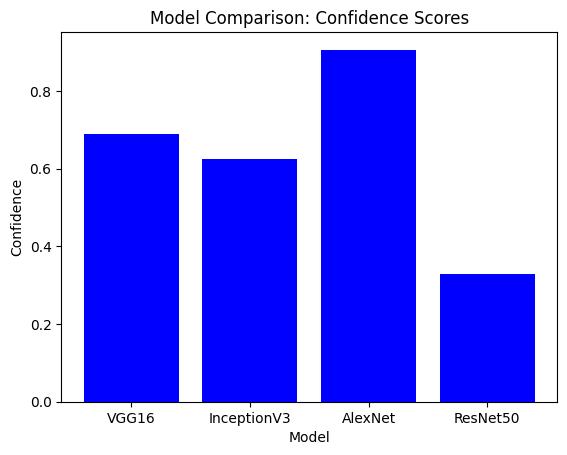

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


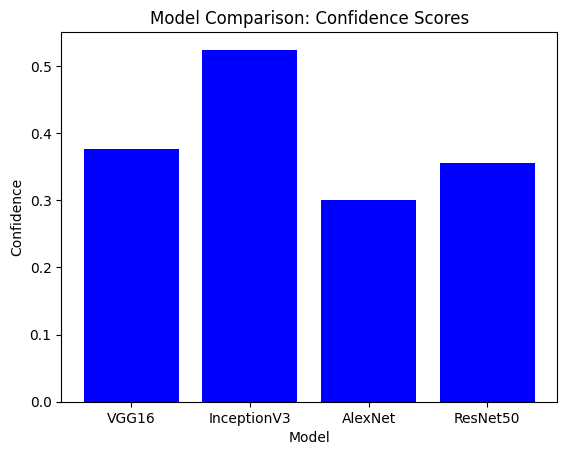

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


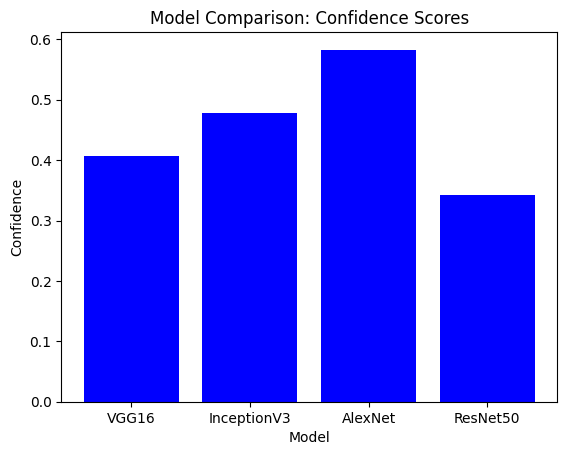

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


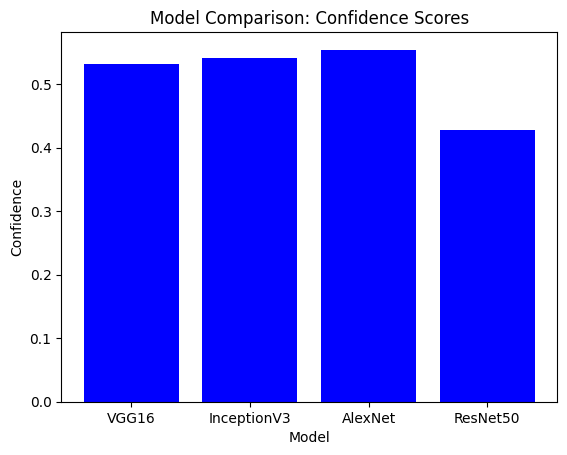

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load models (as before)
model_vgg16 = load_model('alzheimer_vgg16_40.h5')
model_inception = load_model('alzheimer_inception_40.h5')
model_alexnet = load_model('alzheimer_alexnet_40.h5')
model_resnet50 = load_model('alzheimer_resnet50_40.h5')

# Define the image size
img_size = (150, 150)

# Function to make a prediction and display results
def compare_models(image_path, models, class_indices):
    # Load the image
    img = load_img(image_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Initialize a dictionary to store predictions
    predictions = {}

    for model_name, model in models.items():
        pred = model.predict(img_array)
        predicted_class = np.argmax(pred, axis=1)[0]
        class_labels = {v: k for k, v in class_indices.items()}
        predicted_label = class_labels[predicted_class]
        predictions[model_name] = pred[0]  # Store the confidence scores

    # Plotting the confidence scores for each model
    model_names = list(predictions.keys())
    confidence_scores = [np.max(predictions[model_name]) for model_name in model_names]

    plt.bar(model_names, confidence_scores, color='blue')
    plt.title("Model Comparison: Confidence Scores")
    plt.ylabel("Confidence")
    plt.xlabel("Model")
    plt.show()

# Path to the image you want to test
image_path1 = "/content/Combined Dataset/test/Mild Impairment/1 (10).jpg"
image_path2 = "/content/Combined Dataset/test/Moderate Impairment/13 (2).jpg"
image_path3 = "/content/Combined Dataset/test/No Impairment/1 (16).jpg"
image_path4 = "/content/Combined Dataset/test/Very Mild Impairment/1 (10).jpg"
class_indices = {'Mild Impairment': 0, 'Moderate Impairment': 1, 'No Impairment': 2, 'Very Mild Impairment': 3}

# List of models
models = {
    'VGG16': model_vgg16,
    'InceptionV3': model_inception,
    'AlexNet': model_alexnet,
    'ResNet50': model_resnet50
}

# Compare models
compare_models(image_path1, models, class_indices)
compare_models(image_path2, models, class_indices)
compare_models(image_path3, models, class_indices)
compare_models(image_path4, models, class_indices)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Average Confidence Scores for Each Model:
VGG16: 0.5010
InceptionV3: 0.5419
AlexNet: 0.5859
ResNet50: 0.3630


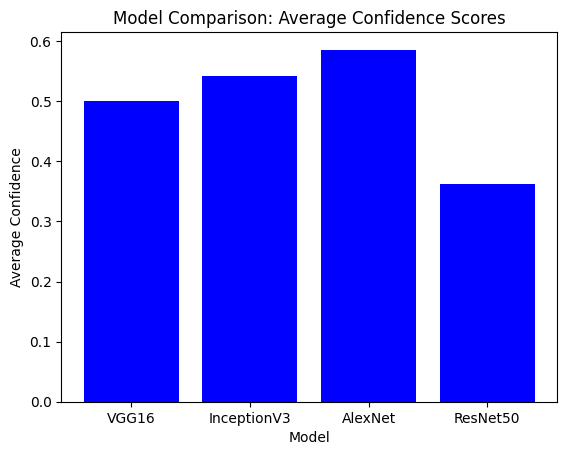


Best Model: AlexNet


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load models (as before)
model_vgg16 = load_model('alzheimer_vgg16_40.h5')
model_inception = load_model('alzheimer_inception_40.h5')
model_alexnet = load_model('alzheimer_alexnet_40.h5')
model_resnet50 = load_model('alzheimer_resnet50_40.h5')

# Define the image size
img_size = (150, 150)

# Function to compare models and accumulate confidence scores
def compare_models(image_paths, models, class_indices):
    # Initialize a dictionary to store cumulative confidence scores for each model
    model_confidence_scores = {model_name: [] for model_name in models.keys()}

    for image_path in image_paths:
        # Load the image
        img = load_img(image_path, target_size=img_size)
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Initialize a dictionary to store predictions for the current image
        predictions = {}

        for model_name, model in models.items():
            pred = model.predict(img_array)
            predicted_class = np.argmax(pred, axis=1)[0]
            class_labels = {v: k for k, v in class_indices.items()}
            predicted_label = class_labels[predicted_class]
            predictions[model_name] = pred[0]  # Store the confidence scores

        # Store the maximum confidence score for each model for this image
        for model_name, score in predictions.items():
            model_confidence_scores[model_name].append(np.max(score))

    # Calculate average confidence scores for each model
    avg_confidence_scores = {model_name: np.mean(scores) for model_name, scores in model_confidence_scores.items()}

    return avg_confidence_scores

# Path to the images you want to test
image_paths = [
    "/content/Combined Dataset/test/Mild Impairment/1 (10).jpg",
    "/content/Combined Dataset/test/Moderate Impairment/13 (2).jpg",
    "/content/Combined Dataset/test/No Impairment/1 (16).jpg",
    "/content/Combined Dataset/test/Very Mild Impairment/1 (10).jpg"
]

class_indices = {'Mild Impairment': 0, 'Moderate Impairment': 1, 'No Impairment': 2, 'Very Mild Impairment': 3}
# List of models
models = {
    'VGG16': model_vgg16,
    'InceptionV3': model_inception,
    'AlexNet': model_alexnet,
    'ResNet50': model_resnet50
}

# Compare models and get the average confidence scores
avg_confidence_scores = compare_models(image_paths, models, class_indices)

# Print out the average confidence scores for each model
print("Average Confidence Scores for Each Model:")
for model_name, score in avg_confidence_scores.items():
    print(f"{model_name}: {score:.4f}")

# Plot the average confidence scores for each model
model_names = list(avg_confidence_scores.keys())
confidence_scores = list(avg_confidence_scores.values())

plt.bar(model_names, confidence_scores, color='blue')
plt.title("Model Comparison: Average Confidence Scores")
plt.ylabel("Average Confidence")
plt.xlabel("Model")
plt.show()

# Identify the best model based on the highest average confidence score
best_model = max(avg_confidence_scores, key=avg_confidence_scores.get)
print(f"\nBest Model: {best_model}")
